# Interpolation
___

**Remarks**
- Code will need to be modified a bit to reflect the use of a certain group of data instead of all data

In [16]:
import numpy as np
import pandas as pd
import os
import pickle

import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
from itertools import combinations

# from scipy.spatial.distance import pdist
# from scipy.stats import chisquare, chi2
from scipy.stats import ttest_1samp, t

from pykrige.ok import OrdinaryKriging
from pykrige.rk import Krige
import pykrige.kriging_tools as kt

from sklearn.model_selection import cross_val_predict

from joblib import Parallel, delayed
import multiprocessing

In [129]:
import prepostprocessing.pre_processing as preproc
import prepostprocessing.post_processing as postproc
import nugget_estimation.kriging_tools as krigingtools
import nugget_estimation.detrending as detrending
import plots.plots as plots
import prepostprocessing.cleaning as cleaning
import cross_validation.leave_one_out_cross_validation as loocv

import qapf.qapf as qapf
import statistics.ttest as ttest
import statistics.simulations as sim

import toolbox.toolbox as tb

In [18]:
# Load jupyter extension to reload packages before executing user code.
# https://ipython.readtheMLcs.io/en/stable/config/extensions/autoreload.html
%load_ext autoreload
# Reload all packages (except those excluded by %aimport) every time before executing the Python code typed.
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


**Remark below**

In [19]:
coordinates_latlon = preproc.load_obj("coordinates_area1")
coordinates_utm = preproc.load_obj("coordinates_utm_area1")
mineralogy = preproc.load_obj("mineralogy_area1")
mineralogy_clr = preproc.load_obj("mineralogy_clr_area1")
mineralogy_pca = preproc.load_obj("mineralogy_pca_area1")
mineralogy_pca_df = preproc.load_obj("mineralogy_pca_area1_df")
metadata = preproc.load_obj("metadata_area1")

In [20]:
mineralogy_clr

,SiO2,TiO2,Al2O3,Fe2O3,FeO,MnO,MgO,CaO,Na2O,K2O,P2O5,l.i.,oth
2,5.125860,-1.558752,3.056369,-1.028123,0.164015,-3.168190,-0.172457,-0.305989,1.576743,2.373074,-2.251899,0.050686,-3.861337
6,4.951608,-0.933991,2.973476,-1.540127,1.110765,-2.926421,-1.252445,0.085841,1.678749,1.946229,-1.540127,-0.528526,-4.025033
9,4.994124,-1.897248,3.046179,-0.339103,0.993124,-3.283542,0.197698,-0.480182,1.544772,1.989458,-2.030779,-0.757813,-3.976689
10,5.175910,-1.491047,3.296445,-0.903260,0.523856,-3.100485,-1.714191,-0.080060,1.833989,2.359101,-2.695020,0.588395,-3.793632
11,4.944215,-1.316003,2.981736,-0.286384,0.858749,-2.925441,-1.251465,0.036390,1.722150,2.071771,-2.637759,-0.173906,-4.024053
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4538,3.707810,-0.704122,2.476310,0.649502,1.063540,-3.343179,1.053736,1.432577,1.178609,0.568844,-1.733741,-1.397269,-4.952617
4552,3.807776,-0.118307,2.586197,0.916357,1.238805,-2.899785,1.091842,1.600025,1.091842,0.756424,-4.845695,-0.379787,-4.845695
4574,3.693508,-0.515793,2.481129,0.812291,0.936712,-3.847998,1.135609,1.614420,1.151464,0.447017,-1.480874,-1.480874,-4.946610
4585,3.498389,-0.265669,2.388656,0.322118,1.000195,-2.735308,0.553772,1.139674,1.075387,0.408060,-1.144219,-1.107852,-5.133203


## EDA
___

In [21]:
# Get number of control points that will be used
number_of_control_points = coordinates_utm.shape[0]
number_of_control_points

1623

In [22]:
coordinates_utm

,Y_UTM,X_UTM,ZoneNumber,ZoneLetter
2,1.821304e+06,6.200334e+06,47,T
6,1.535769e+06,5.720307e+06,47,T
9,1.494703e+06,5.662488e+06,47,T
10,1.517477e+06,5.756850e+06,47,T
11,1.327736e+06,5.680588e+06,47,T
...,...,...,...,...
4538,1.706776e+06,5.987460e+06,47,T
4552,1.719856e+06,6.116532e+06,47,T
4574,1.805569e+06,6.115360e+06,47,T
4585,1.850992e+06,6.089365e+06,47,T


In [23]:
coordinates_utm = coordinates_utm.rename({"X_UTM": "Y", "Y_UTM": "X"}, axis=1)

In [24]:
# FILL IN SHORT NAME HERE THAT WILL BE USED WHEN SAVING THE PLOT (e.g. "G1")
group_name = "area1"

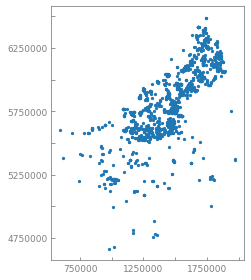

In [25]:
# Plot control points with labels
plots.plot_map_with_control_points(coordinates_utm, group_name, label_size=4, subset=["X", "Y"],
                                   show_labels=False,
                                  skip_xaxis_label=2, skip_yaxis_label=2, 
                                  skip_xaxis_start=1, skip_yaxis_start=1)

In [26]:
# Show unique zone letters and zone numbers of utm coordinates
coordinates_utm["ZoneNumber"].unique()
coordinates_utm["ZoneLetter"].unique()

array(['T'], dtype=object)

**So you appear to have data points with the exact same location? --> min_lag_distance=0  
This may be what is causing the linalg error later on but need to check it in more detail.  
If I remember correctly, I also encoutered this error when I started of with my datasets.  
Will look into it and (hopefully) get you a solution tomorrow.**

In [27]:
# Calculate minimum and maxmin lag distance between two points of the dataset
distance_matrix = krigingtools.calculate_and_sort_square_distance_matrix(coordinates_utm[["X", "Y"]])

min_lag_distance = np.amin(distance_matrix)
max_lag_distance = np.amax(distance_matrix)
min_lag_distance, max_lag_distance

(0.0018117179710922212, 1972740.5439505253)

(array([7.60640e+04, 1.11460e+05, 1.61582e+05, 2.03936e+05, 2.07092e+05,
        2.09568e+05, 1.98496e+05, 1.76878e+05, 1.47396e+05, 1.57578e+05,
        1.36780e+05, 1.35990e+05, 1.24020e+05, 1.04774e+05, 9.35400e+04,
        7.78680e+04, 6.80680e+04, 5.20380e+04, 4.08660e+04, 2.78820e+04,
        2.42340e+04, 2.28700e+04, 1.52060e+04, 1.43360e+04, 1.33980e+04,
        8.87200e+03, 7.23000e+03, 5.41400e+03, 3.07400e+03, 1.97600e+03,
        1.24000e+03, 9.32000e+02, 5.02000e+02, 6.20000e+02, 2.90000e+02,
        1.90000e+02, 1.24000e+02, 8.00000e+01, 3.40000e+01, 8.00000e+00]),
 array([1.81171797e-03, 4.93185154e+04, 9.86370289e+04, 1.47955542e+05,
        1.97274056e+05, 2.46592570e+05, 2.95911083e+05, 3.45229597e+05,
        3.94548110e+05, 4.43866624e+05, 4.93185137e+05, 5.42503651e+05,
        5.91822164e+05, 6.41140678e+05, 6.90459192e+05, 7.39777705e+05,
        7.89096219e+05, 8.38414732e+05, 8.87733246e+05, 9.37051759e+05,
        9.86370273e+05, 1.03568879e+06, 1.08500730e+06

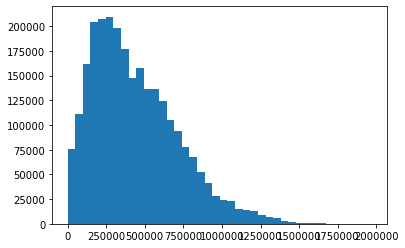

In [28]:
plt.hist(distance_matrix.flatten(), bins=40)

In [29]:
np.where(distance_matrix == 0)

(array([], dtype=int64), array([], dtype=int64))

### remark

no points where distance is 0 --> good 
**Yep**

## Critical distance estimation
___

In [55]:
# Range (lag distance at which the sill is reached; in meters)

# Depending on how many principal components you will use, 
# you will have to add more entries to this list.

# Modified the range since variograms are not correct yet
range_ = [100000] * 15
# range_ = [10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000]

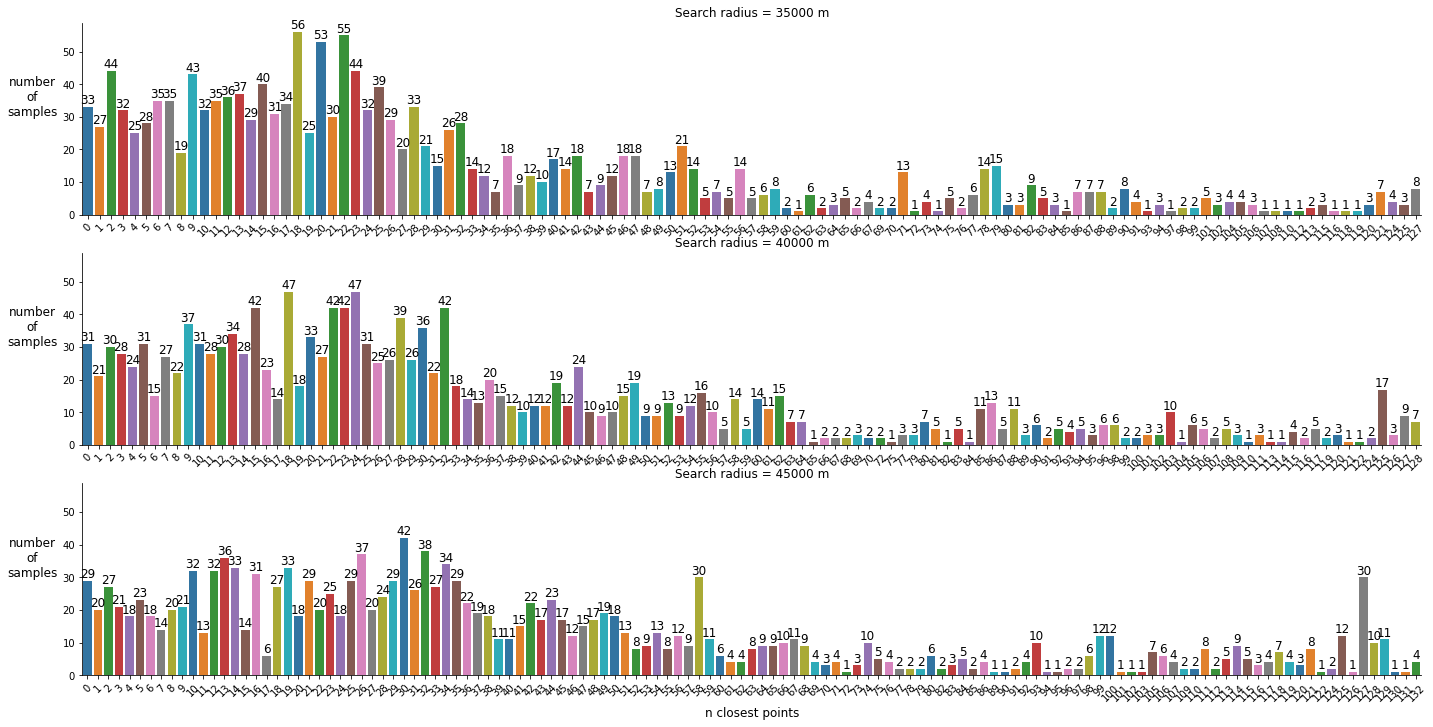

In [56]:
# You can adjust the radius parameters below to change the slider settings
# to visualize the figures interactively
plots.interactive_plot_search_radius(coordinates_utm, orient='rows', 
                                     radius_default=50000, # Default slider position
                                     radius_min=40000,  # Slider start
                                     radius_max=40000, # Slider stop
                                     radius_step=5000,  # Slider step
                                     radius_offset=5000) # Offset between visualizations shown

# The x-axis stands for 'n_neighbours'

In [57]:
# Critical distance (in meters)
# This is the distance where at least 95% of your samples
# will have at least 3 neighbours within that distance

# You can refine this value later on, or we can use the range 
# instead of the critical distance as the only value for the search radius
critical_distance = 45000

### remark
set the search_radius below to critical_distance like said in the mail (maybe its not necessairy here, but the values obtained are the same) and what also already was done in point 1.11 contourplots
at certain steps, the search_radii is set to [range_[0]]. I don't know if this also has to be changed, so i didn't change it 

In [172]:
# This is basically creating a list of how many neighbours each data point has 
# within the critical_distance and within the range
nvalues_control_points = {}

for radius in (0.05, critical_distance, range_[0]):
    temp = krigingtools.find_points_within_search_radius(
               krigingtools.calculate_and_sort_square_distance_matrix(coordinates_utm),
               search_radius=critical_distance
           )
    nvalues_control_points[radius] = pd.Series(temp, index=coordinates_utm.index)

In [173]:
# Number of samples that may still have less than 3 neighbours within the critical distance
int(number_of_control_points * 0.05)

81

In [174]:
# Check number of samples outside of critical distance
samples_outside_critical_distance = nvalues_control_points[critical_distance][nvalues_control_points[critical_distance] < 3].index.tolist()
len(samples_outside_critical_distance)

76

In [171]:
# Overview of samples that are outside search_radius
mineralogy_pca_df.loc[samples_outside_critical_distance, :]

,PC01,PC02,PC03,PC04,PC05,PC06,PC07,PC08,PC09,PC10,PC11,PC12,PC13
132,1.502967,-0.311824,-0.890603,0.310657,-0.974952,0.036220,0.131167,-0.464630,0.884523,-0.054938,0.123326,0.016263,-5.149730e-16
353,1.606711,-1.084463,-0.240394,0.098127,-0.448377,0.030684,0.279308,-0.735320,0.491972,0.202456,0.035708,0.038046,5.337935e-16
583,1.215664,0.100702,0.741930,-0.435791,0.841300,-0.845726,0.925892,-0.362688,0.072011,-0.170368,0.148751,0.064719,-1.378754e-16
600,0.251152,-0.147518,0.654400,0.323570,-0.011512,-0.228044,-0.451445,0.446382,-0.103457,-0.113629,-0.002477,0.086367,-3.252676e-16
632,0.291180,-0.140176,-0.989211,0.093542,0.816890,-0.136472,0.071352,0.247929,0.459338,0.116902,0.012172,0.090045,3.092506e-16
676,-0.189593,-0.371978,-0.025845,-0.393098,0.902950,-0.180033,0.330551,0.040066,0.083593,-0.147432,0.000253,0.221947,3.680546e-17
784,1.536541,0.874389,0.001791,-0.437055,1.134900,1.026145,1.551609,0.127147,-0.034597,0.100853,-0.091115,0.081004,1.087511e-16
823,0.144683,-0.618005,-0.279740,-0.996411,-1.010822,0.538425,-0.426684,0.341644,0.600391,-0.411004,0.501598,-0.075955,-2.723735e-16
1046,1.165929,-0.946765,-0.591386,0.495880,0.126029,-0.424130,0.115003,-0.144722,0.140816,-0.090482,-0.004047,0.034513,1.497605e-16
1273,0.148014,-0.420504,-0.228198,-0.346376,0.540154,0.193629,-0.359615,0.270068,-0.082952,-0.332883,0.094395,0.029561,7.578147e-16


____

In [62]:
# Create dataframe with duplicates grouping and count info
# https://stackoverflow.com/questions/53760860/pd-duplicated-groups-of-duplicates
cols = ["X", "Y"]
df1 = coordinates_utm[coordinates_utm.duplicated(subset=cols, keep=False)].copy()
df1 = df1.sort_values(cols)
df1['group'] = 'g' + (df1.groupby(cols).ngroup() + 1).astype(str)
# df1['group'] = 'g' + f"{df1['group'].str()[1:]:02d}"
df1['duplicate_count'] = df1.groupby(cols)['X'].transform('size')

In [63]:
df1.sort_index().sort_values(by="duplicate_count", ascending=False)

,X,Y,ZoneNumber,ZoneLetter,group,duplicate_count


In [64]:
# Get list of duplicate groups which hold list of corresponding items
group_items = df1.groupby("group").apply(lambda x: x.index.tolist())
group_items

""
group


In [65]:
group_items_df = pd.DataFrame(group_items)

In [66]:
# Create dictionary of droup items for easy reference
group_items_dict = {k:v for (k, v) in zip(group_items.index, group_items.values)}

In [67]:
for group, items in group_items_dict.items():
    print(group)
    coordinates_latlon.loc[items, :]

In [68]:
for group, items in group_items_dict.items():
    print(group)
    metadata.loc[items, :]

In [69]:
for group, items in group_items_dict.items():
    print(group)
    mineralogy.loc[items, :]

In [70]:
# Check to see how many points are on a shared location
nvalues_control_points[0.05].sum()

4

### remark
still 4 points on shared location --> strange, code above doesn't indicate this (also no LinAlg error anymore)  
**4 points within 0.05 m from eachother to be clear; that's why you don't get an error**

___

## Create high resolution grids
____

In [71]:
# Determine (wide) grid boundaries
X = coordinates_utm.iloc[:, 0].values
Xmin = np.min(X) - critical_distance * 1.05
Xmax = np.max(X) + critical_distance * 1.05

Y = coordinates_utm.iloc[:, 1].values
Ymin = np.min(Y) - critical_distance * 1.05, 
Ymax = np.max(Y) + critical_distance * 1.05

coordinates_boundaries = np.array([[Xmin, Xmax], [Ymin, Ymax]])
coordinates_boundaries

array([[542986.1735325938, 2020658.93068602],
       [(4618798.114899939,), 6533338.626403356]], dtype=object)

###  error : 
key not defined. I removed it and it worked, but this was maybe something important

print("smallest dimension", key, smallest_dimension) -->  print("smallest dimension", smallest_dimension)

print("theoretical x spacing: ", key, dx) --> print("theoretical x spacing: ", dx)

print("xy grid: ", key, len(xgrid), len(ygrid), "\n") --> print("xy grid: ", len(xgrid), len(ygrid), "\n")



**The 'key' shouldn't have been there anymore, still a remnant from my notebooks where I defined the grids for all plutons/areas in a for loop.  
The key would print which pluton was being requested. Good thing you removed it and thus solved the error.**

In [72]:
# Set approximate number of points along each axis
n_points = 300

temp = {}
x, y = coordinates_boundaries

temp["x_start (m)"] = int(np.floor(x[0]))
temp["x_end (m)"] = int(np.floor(x[1]))
temp["y_start (m)"] = int(np.floor(y[0]))
temp["y_end (m)"] = int(np.floor(y[1]))

print("x", x)
print("y", y)

temp["x_range (m)"] = int(np.floor(x[1])) - int(np.floor(x[0]))
temp["y_range (m)"] = int(np.floor(y[1])) - int(np.floor(y[0]))
print("x range: ", temp["x_range (m)"])
print("y range: ", temp["y_range (m)"])

ranges = {"x": temp["x_range (m)"],
          "y": temp["y_range (m)"],
         }

threshold = 10000000
for dimension, ranger in ranges.items():
    if ranger < threshold:
        smallest_dimension = dimension
        threshold = ranger
print("smallest dimension", smallest_dimension)

x_spacing, dx = np.linspace(x[0], x[1], n_points, retstep=True)
y_spacing, dy = np.linspace(y[0], y[1], n_points, retstep=True)

steps = {"x": dx,
         "y": dy,
        }

print("theoretical x spacing: ", dx)

xgrid = np.arange(x[0]-dx, x[1]+dx, steps[smallest_dimension])
ygrid = np.arange(y[0]-dy, y[1]+dy, steps[smallest_dimension])

print("actual x spacing: ", xgrid[1] - xgrid[0])
print("actual y spacing: ", ygrid[1] - ygrid[0])

temp["x_spacing (m)"] = np.round(xgrid[1] - xgrid[0], 2)
temp["y_spacing (m)"] = np.round(ygrid[1] - ygrid[0], 2)

print("Number of points: ", len(xgrid) * len(ygrid))
print("xy grid: ", len(xgrid), len(ygrid), "\n")

temp["#xgrid_points"] = len(xgrid)
temp["#ygrid_points"] = len(ygrid)
temp["#total_grid_nodes"] = len(xgrid) * len(ygrid)

coordinates_grids = [xgrid, ygrid]
coordinates_grids_details = temp

# Assigned to a different variable (name) because later on 'grid' gets used in the code
grid = coordinates_grids

x [542986.1735325938 2020658.93068602]
y [(4618798.114899939,) 6533338.626403356]
x range:  1477672
y range:  1914540
smallest dimension x
theoretical x spacing:  4942.049355028182
actual x spacing:  4942.049355028197
actual y spacing:  4942.049355028197
Number of points:  117390
xy grid:  301 390 



## Classification map
___

We will have to decide on a certain classification scheme before we could use this.  
Another option might be to use a condensed version of the 'type_granite' column.

**Yep**

## Detrending
____

### remark
R² values are very low --> no trends are present in the dataset

**Looks good indeed!**

In [73]:
# Check if there is a trend present in the data
# This is the case if R² is above say 0.70 

for component in mineralogy_pca_df.columns.tolist()[:-1]:
    for order in [1, 2]:
        print("R² for", component, "order =", order, ":")
        detrending.detrend(coordinates_utm, 
                           mineralogy_pca_df[component], 
                           order=order, 
                           verbose=False, 
                           plot_points=False)[1]

R² for PC01 order = 1 :
R² for PC01 order = 2 :
R² for PC02 order = 1 :
R² for PC02 order = 2 :
R² for PC03 order = 1 :
R² for PC03 order = 2 :
R² for PC04 order = 1 :
R² for PC04 order = 2 :
R² for PC05 order = 1 :
R² for PC05 order = 2 :
R² for PC06 order = 1 :
R² for PC06 order = 2 :
R² for PC07 order = 1 :
R² for PC07 order = 2 :
R² for PC08 order = 1 :
R² for PC08 order = 2 :
R² for PC09 order = 1 :
R² for PC09 order = 2 :
R² for PC10 order = 1 :
R² for PC10 order = 2 :
R² for PC11 order = 1 :
R² for PC11 order = 2 :
R² for PC12 order = 1 :
R² for PC12 order = 2 :


## Variogram modelling
___

* Variogram model (str)
* Sill (float)
* Range (float)
* Nugget (float)
* Number of lag bins (int)
* Weighted (Bool)

In [74]:
# Nugget (variance at lag=0 metric)

# Since we are not dealing with point count data here,
# we can not use the formulas from our paper we have talked about
# Therefore I would just start with nugget=0 and perhaps later change this

# Depending on how many principal components you will use, 
# you will have to add more entries to this list.
nugget_ = [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,]

In [75]:
PC_nr_list = [nr[2:] for nr in mineralogy_pca_df.columns]
PC_nr_list

['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13']

In [76]:
# Sill (total variance metric)

# A 'list comprehension' construction is used here
sill_ = [mineralogy_pca_df.loc[:, f"PC{i}"].values.var(ddof=1) 
         for i in PC_nr_list]

In [77]:
# Variogram model parameters dictionary

variogram_model_parameters = {}

for i, PC in enumerate(mineralogy_pca_df.columns):
    parameters = {}
    parameters["sill"] = sill_[i]
    parameters["range"] = range_[i]
    parameters["nugget"] = nugget_[i]
        
    variogram_model_parameters[PC] = parameters

In [78]:
# Variogram model

# You can choose between ["exponential", "linear", "spherical", "power", "gaussian"]
# see https://pykrige.readthedocs.io/en/latest/variogram_models.html for equations
variogram_model = "exponential"

In [79]:
# Number of lag bins

n_lags = int(np.floor(np.sqrt(coordinates_utm.shape[0])))
n_lags

40

In [80]:
# Set utm coordinates to use in variogram

X = coordinates_utm.iloc[:, 0].values
Y = coordinates_utm.iloc[:, 1].values

### remark
LinAlg error = gone, but Q1, Q2 and Cr values still far away from ideal values --> adjusting parameters still have to be done

**Will look into this. Proposed solution should not be necessary.**

**It looks like we only need to use the first 9 PCs as the later ones all have variograms that are 'flipped', meaning they are just producing nonsense.**  
**Changed the for loop to only use the first 9 PCs**

**Disabled the statistics calculation as they take quite some time to calculate. --> Visual inspection of variograms may suffice for now**  
**Also removed the text in the variogram plots (temporarily), so that you can more easily see the points.**

PC01
Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'exponential' Variogram Model
Partial Sill: 1.2355789231124064
Full Sill: 1.2355789231124064
Range: 100000
Nugget: 0.0 



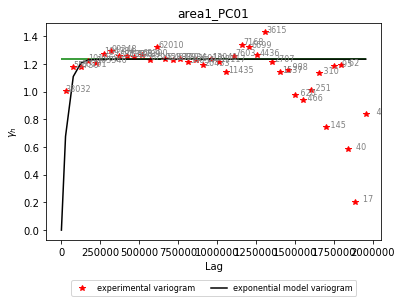

Calculating statistics on variogram model fit...
PC02
Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'exponential' Variogram Model
Partial Sill: 0.7856369803662919
Full Sill: 0.7856369803662919
Range: 100000
Nugget: 0.0 



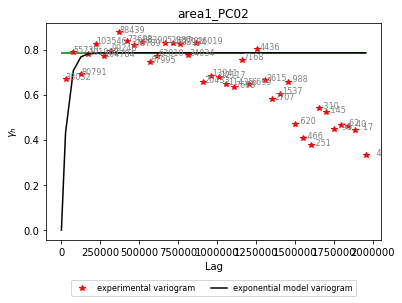

Calculating statistics on variogram model fit...
PC03
Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'exponential' Variogram Model
Partial Sill: 0.5845313615265494
Full Sill: 0.5845313615265494
Range: 100000
Nugget: 0.0 



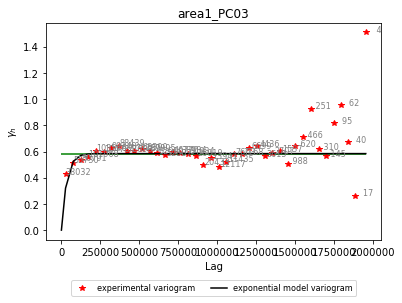

Calculating statistics on variogram model fit...
PC04
Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'exponential' Variogram Model
Partial Sill: 0.4825017553347939
Full Sill: 0.4825017553347939
Range: 100000
Nugget: 0.0 



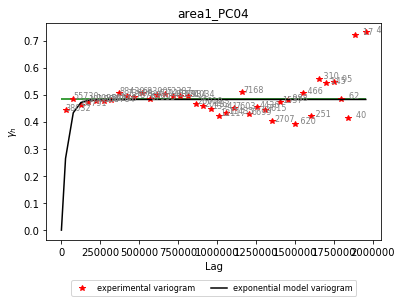

Calculating statistics on variogram model fit...
PC05
Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'exponential' Variogram Model
Partial Sill: 0.31221772103040224
Full Sill: 0.31221772103040224
Range: 100000
Nugget: 0.0 



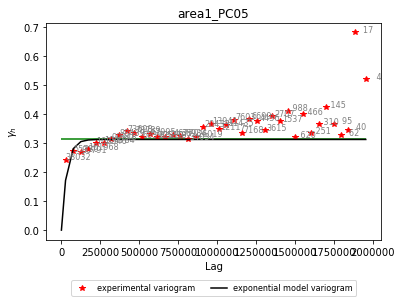

Calculating statistics on variogram model fit...
PC06
Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'exponential' Variogram Model
Partial Sill: 0.29202666140449934
Full Sill: 0.29202666140449934
Range: 100000
Nugget: 0.0 



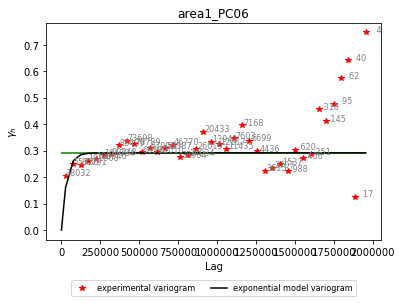

Calculating statistics on variogram model fit...
PC07
Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'exponential' Variogram Model
Partial Sill: 0.21826072434551144
Full Sill: 0.21826072434551144
Range: 100000
Nugget: 0.0 



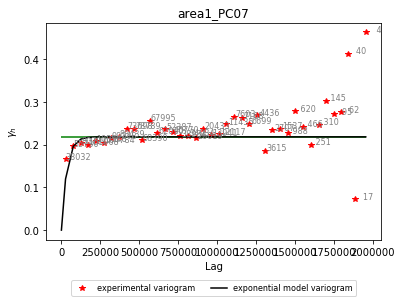

Calculating statistics on variogram model fit...
PC08
Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'exponential' Variogram Model
Partial Sill: 0.21003942354637867
Full Sill: 0.21003942354637867
Range: 100000
Nugget: 0.0 



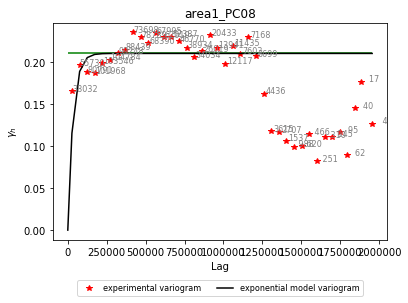

Calculating statistics on variogram model fit...
PC09
Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'exponential' Variogram Model
Partial Sill: 0.14080651440394873
Full Sill: 0.14080651440394873
Range: 100000
Nugget: 0.0 



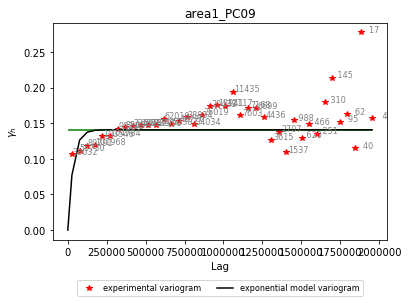

Calculating statistics on variogram model fit...
PC10
Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'exponential' Variogram Model
Partial Sill: 0.04805327747900484
Full Sill: 0.04805327747900484
Range: 100000
Nugget: 0.0 



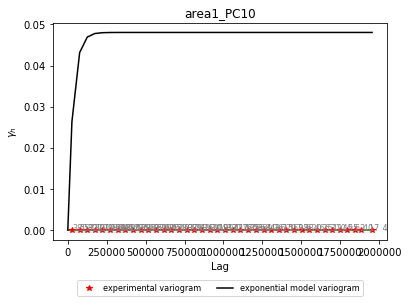

Calculating statistics on variogram model fit...
PC11
Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'exponential' Variogram Model
Partial Sill: 0.015282152925925382
Full Sill: 0.015282152925925382
Range: 100000
Nugget: 0.0 



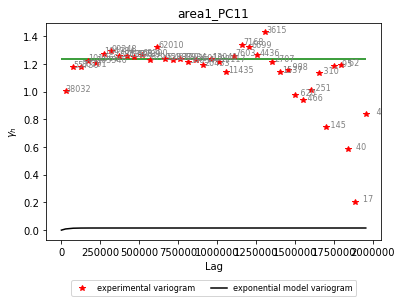

Calculating statistics on variogram model fit...
PC12
Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'exponential' Variogram Model
Partial Sill: 0.005108958109760523
Full Sill: 0.005108958109760523
Range: 100000
Nugget: 0.0 



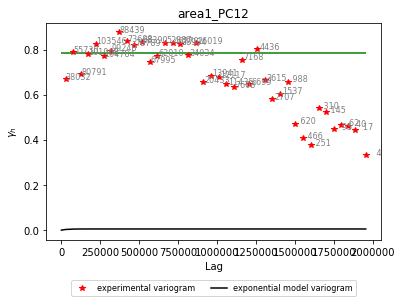

Calculating statistics on variogram model fit...
Wall time: 17.6 s


In [81]:
%%time
# Initialize empty dictionary
variograms = {}

# Loop though the diiferent principal components
for component in mineralogy_pca_df.columns.tolist()[:-1]:
    print(component)
    # Subset principal component to use
    data = mineralogy_pca_df.iloc[:, int(component[-1])-1].values
    variograms[component] = \
        OrdinaryKriging(X, Y, data,
                        variogram_model='exponential',
                        variogram_parameters=variogram_model_parameters[component],
                        nlags=n_lags,
                        verbose=True,
                        enable_statistics=False,
                        enable_plotting=True,
                        weight=True,
                        saveplot=True,
                        coordinates_type='euclidean',
                        saveloc="../_FIGURES/variograms/",
                        principal_component=component,
                        pluton=group_name)
    
# NOTE that ideally Q1 is close to zero, Q2 is close to 1, and cR is as small as possible.

## Leave One Out Cross Validation (LOOCV) of PCA
____

In [82]:
# If you have run the cross validation before you can load the results by
# running this cell and don't have to run the next cell anymore.
CV_results = preproc.load_obj("CV_results_fast")

**The error below should be fixed now. --> Confirmed, but other error due to NaN values? --> Actual error is also related to linalg error from above**

**The cv_param°dict has been rewritten so that the parameters can be set for each PC.  
Was not sure about the numbers of PCs that you are going to use so I quickly created a loop since the parameters you use aree the same over all PCs (except for variogram_model_parameters).**

**Also made a small change in the function that gets called.  
Basically what happened was that a list was being passed with one item whereas it just expected that one item (without being in a list).  
So just added 'list_name[0]' in the function instead of 'list_name' and all should be good now.**

In [83]:
# Use this cross validation to check the hyper-parameters of your chosen variogram model 
# such as the search_radius, variogram_model, lag_bins etc.

# Cross validation parameter dictionary to use
# You can remove or add options here which will decrease or increase the number 
# of combinations of parameters the cross validation will run
cv_param_dict = {}

for component in mineralogy_pca_df.columns.tolist()[:-1]:
    cv_param_dict[component] = {"method": ["ordinary"],
                                "variogram_model": ["exponential", "spherical"],
                                "variogram_model_parameters": [variogram_model_parameters[component]],
                                "nlags": [n_lags],
                                "weight": [True],
                                "n_closest_points": [number_of_control_points],
                                "search_radius": [range_[0]]
                                }

# The CV function below uses parallel processing to speed things up
# Your CPU will thus reach 100% probably
# To reduce the number of parallel processes to use you can change the following value
# Defaults to -1 to use all available CPU cores; change to number between 1 and 8 e.g. 
# depending on how many cores your CPU has
n_jobs = -1 

In [84]:
%%time
# Run CV and get estimators (using default MSE scorer)

# Instead of running the CV for all the PCs, let's start with only the first 3 
# to get an idea of what are the best parameters to use for the first 3 PCs.
# In a later step we can then obtain the best parameters for all PCs that have 
# a sensible variogram; here this would mean up to and including PC09.
# To specify which PCs to use, you can pass them in as list to the 'components_to_use' variable

# Another change I've made, is that instead of performing leave-one-out-CV 
# where the train set is equal to n_sample - 1 and the test set is equal to 1,
# it makes sense to here use a different strategy, since you're dealing with many more samples.
# Therefore I've included the 'cv_folds' parameter where you can specify 
# the number of train/test groups you want to use during CV
# Let's start with ten groups, which basically means that 
# you use 90% of the samples as train set and 10% as test test
# and this in 10 combinations.

# A a later stage we could change the CV to use a statified cv_fold
# meaning that it ensures for example that for every train/test grouping of the 10 groups
# equal numbers of samples of spcified grouping variable are used 
# (for example your time category or classification later on)

# I've also included the '%%time' statement at the beginning of the cell,
# so that at the end of the calculation you can see how much time it took.

# Have a look here if you want some background info on the CV method used:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

estimators = loocv.perform_loocv(mineralogy_pca_df,
                                 coordinates_utm,
                                 cv_param_dict,
                                 n_jobs=n_jobs,
                                 cv_folds=10,
                                 components_to_use=["PC01", "PC02", "PC03"])

PC01
Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done  10 out of  20 | elapsed:   11.9s remaining:   11.9s
[Parallel(n_jobs=-1)]: Done  15 out of  20 | elapsed:   12.1s remaining:    4.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   14.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   14.7s finished
C:\Users\Sebastian\Anaconda3\envs\main\lib\site-packages\sklearn\model_selection\_search.py:825: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


PC02
Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done  10 out of  20 | elapsed:    8.9s remaining:    8.9s
[Parallel(n_jobs=-1)]: Done  15 out of  20 | elapsed:    9.1s remaining:    3.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   11.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   11.7s finished


PC03
Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done  10 out of  20 | elapsed:    8.9s remaining:    8.9s
[Parallel(n_jobs=-1)]: Done  15 out of  20 | elapsed:    9.1s remaining:    3.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   11.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   11.6s finished


Wall time: 40.5 s


In [85]:
%%time
# Run CV and get estimators (using default MSE scorer)

# Instead of running the CV for all the PCs, let's start with only the first 3 
# to get an idea of what are the best parameters to use for the first 3 PCs.
# In a later step we can then obtain the best parameters for all PCs that have 
# a sensible variogram; here this would mean up to and including PC09.
# To specify which PCs to use, you can pass them in as list to the 'components_to_use' variable

# Another change I've made, is that instead of performing leave-one-out-CV 
# where the train set is equal to n_sample - 1 and the test set is equal to 1,
# it makes sense to here use a different strategy, since you're dealing with many more samples.
# Therefore I've included the 'cv_folds' parameter where you can specify 
# the number of train/test groups you want to use during CV
# Let's start with ten groups, which basically means that 
# you use 90% of the samples as train set and 10% as test test
# and this in 10 combinations.

# A a later stage we could change the CV to use a statified cv_fold
# meaning that it ensures for example that for every train/test grouping of the 10 groups
# equal numbers of samples of spcified grouping variable are used 
# (for example your time category or classification later on)

# I've also included the '%%time' statement at the beginning of the cell,
# so that at the end of the calculation you can see how much time it took.

# Have a look here if you want some background info on the CV method used:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

estimators = loocv.perform_loocv(mineralogy_pca_df,
                                 coordinates_utm,
                                 cv_param_dict,
                                 n_jobs=n_jobs,
                                 cv_folds=10,
                                 components_to_use=[f"PC0{i}" for i in range(1, 10)])

PC01
Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done  10 out of  20 | elapsed:   11.4s remaining:   11.4s
[Parallel(n_jobs=-1)]: Done  15 out of  20 | elapsed:   12.1s remaining:    4.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   14.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   14.4s finished


PC02
Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done  10 out of  20 | elapsed:    9.1s remaining:    9.1s
[Parallel(n_jobs=-1)]: Done  15 out of  20 | elapsed:    9.9s remaining:    3.2s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   12.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   12.7s finished


PC03
Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done  10 out of  20 | elapsed:    8.9s remaining:    8.9s
[Parallel(n_jobs=-1)]: Done  15 out of  20 | elapsed:    9.0s remaining:    2.9s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   11.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   11.8s finished


PC04
Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done  10 out of  20 | elapsed:    8.7s remaining:    8.7s
[Parallel(n_jobs=-1)]: Done  15 out of  20 | elapsed:    9.1s remaining:    3.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   11.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   11.6s finished


PC05
Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done  10 out of  20 | elapsed:    9.0s remaining:    9.0s
[Parallel(n_jobs=-1)]: Done  15 out of  20 | elapsed:   11.0s remaining:    3.6s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   13.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   13.3s finished


PC06
Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done  10 out of  20 | elapsed:    9.0s remaining:    9.0s
[Parallel(n_jobs=-1)]: Done  15 out of  20 | elapsed:   10.5s remaining:    3.4s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   12.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   12.8s finished


PC07
Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done  10 out of  20 | elapsed:    8.5s remaining:    8.5s
[Parallel(n_jobs=-1)]: Done  15 out of  20 | elapsed:   10.2s remaining:    3.3s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   12.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   12.6s finished


PC08
Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done  10 out of  20 | elapsed:    9.3s remaining:    9.3s
[Parallel(n_jobs=-1)]: Done  15 out of  20 | elapsed:   10.8s remaining:    3.5s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   13.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   13.3s finished


PC09
Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done  10 out of  20 | elapsed:    9.2s remaining:    9.2s
[Parallel(n_jobs=-1)]: Done  15 out of  20 | elapsed:   10.2s remaining:    3.3s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   13.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   13.0s finished


Wall time: 2min 3s


In [91]:
# Convert estimators to dict of dataframes
CV_results = loocv.convert_scores_to_df(estimators)

In [92]:
# E.g. check CV_results for PC01
# Check column 'mean_test_score' for results
# lower values are better since the scorer used is the Mean Squared Error (MSE)
CV_results["PC01"]

,rank_test_score,mean_test_score,std_test_score,mean_train_score,param_method,param_variogram_model,param_search_radius
0,2,1.282953,0.562020,5.968505e-22,ordinary,exponential,100000
1,1,1.297981,0.556003,2.424864e-21,ordinary,spherical,100000


In [93]:
# Save CV_results to pickle file for easy use later
# These are the results from the 56min CV above (with only first 3 PCs)
preproc.save_obj(CV_results, "CV_results_summarized")

In [94]:
# Save CV_results to pickle file for easy use later
# These are the results from the 2min CV above (with only first 9 PCs, simple parameters)
preproc.save_obj(CV_results, "CV_results_fast")

In [95]:
# Quick look at best results per PC
loocv.print_best_scores(CV_results)

PC01
rank_test_score                    2
mean_test_score              1.28295
std_test_score               0.56202
mean_train_score         5.96851e-22
param_method                ordinary
param_variogram_model    exponential
param_search_radius           100000
Name: 0, dtype: object


PC02
rank_test_score                    2
mean_test_score             0.744534
std_test_score              0.169685
mean_train_score                   0
param_method                ordinary
param_variogram_model    exponential
param_search_radius           100000
Name: 0, dtype: object


PC03
rank_test_score                    2
mean_test_score             0.566963
std_test_score             0.0564402
mean_train_score                   0
param_method                ordinary
param_variogram_model    exponential
param_search_radius           100000
Name: 0, dtype: object


PC04
rank_test_score                    2
mean_test_score              0.59984
std_test_score             0.0715145
mean_train_score 

## Calculating predictions for best model
____

In [130]:
# Here you can specify the components and search_radii you want to use 
# when performing the kriging and performing the postprocessing calculations
components_to_use = [f"PC0{i}" for i in range(1, 10)]
search_radii = [range_[0]]

In [131]:
estimators_final = {}

for component in components_to_use:  # Changed to only first 9 PCs
    for radius in search_radii:  # Removed critical_distance
        for variable_to_fit in ["estimates", "variances"]:

            estimators_final[f"{component}_{radius}_{variable_to_fit}"] = \
                Krige(method='ordinary',
                      variogram_model=variogram_model,
                      variogram_model_parameters=variogram_model_parameters[component],
                      nlags=n_lags,
                      weight=True,
                      n_closest_points=number_of_control_points,
                      search_radius=radius,
                      variable_to_fit=variable_to_fit)

In [132]:
# Run this cell if you have previously run the next cell and saved its outcome
kriging_predictions = preproc.load_obj("kriging_predictions")

In [133]:
%%time
# You can again change the n_jobs to lower the #CPU cores used for parallel processing
# Also set the cv_folds variable below
cv_folds = 10

kriging_predictions = {}

for component in components_to_use:  # Changed to only first 9 PCs
    for radius in search_radii:  # Removed critical_distance
        for variable_to_fit in ["estimates", "variances"]:
            
            # Let's print out the combination to see where we are in the loops
            print(component, radius, variable_to_fit)
            
            kriging_predictions[f"{component}_{radius}_{variable_to_fit}"] = \
                cross_val_predict(estimators_final[f"{component}_{radius}_{variable_to_fit}"], 
                                  X=np.stack((coordinates_utm["X"],
                                              coordinates_utm["Y"]), axis=1),
                                  y=mineralogy_pca_df[component],
                                  cv=cv_folds,
                                  n_jobs=-1,
                                  verbose=5)

PC01 100000 estimates


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  10 | elapsed:    4.9s remaining:    7.4s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    4.9s remaining:    2.1s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    5.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    5.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


PC01 100000 variances


[Parallel(n_jobs=-1)]: Done   4 out of  10 | elapsed:    2.2s remaining:    3.4s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    2.3s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


PC02 100000 estimates


[Parallel(n_jobs=-1)]: Done   4 out of  10 | elapsed:    2.1s remaining:    3.2s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    2.2s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


PC02 100000 variances


[Parallel(n_jobs=-1)]: Done   4 out of  10 | elapsed:    2.2s remaining:    3.3s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    2.2s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


PC03 100000 estimates


[Parallel(n_jobs=-1)]: Done   4 out of  10 | elapsed:    2.2s remaining:    3.3s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    2.3s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


PC03 100000 variances


[Parallel(n_jobs=-1)]: Done   4 out of  10 | elapsed:    2.1s remaining:    3.1s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    2.1s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


PC04 100000 estimates


[Parallel(n_jobs=-1)]: Done   4 out of  10 | elapsed:    2.1s remaining:    3.2s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    2.2s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


PC04 100000 variances


[Parallel(n_jobs=-1)]: Done   4 out of  10 | elapsed:    2.1s remaining:    3.2s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    2.2s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


PC05 100000 estimates


[Parallel(n_jobs=-1)]: Done   4 out of  10 | elapsed:    2.1s remaining:    3.1s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    2.1s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


PC05 100000 variances


[Parallel(n_jobs=-1)]: Done   4 out of  10 | elapsed:    2.1s remaining:    3.1s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    2.1s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


PC06 100000 estimates


[Parallel(n_jobs=-1)]: Done   4 out of  10 | elapsed:    2.1s remaining:    3.2s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    2.1s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


PC06 100000 variances


[Parallel(n_jobs=-1)]: Done   4 out of  10 | elapsed:    2.1s remaining:    3.1s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    2.1s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


PC07 100000 estimates


[Parallel(n_jobs=-1)]: Done   4 out of  10 | elapsed:    2.2s remaining:    3.4s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    2.3s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


PC07 100000 variances


[Parallel(n_jobs=-1)]: Done   4 out of  10 | elapsed:    2.1s remaining:    3.1s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    2.1s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


PC08 100000 estimates


[Parallel(n_jobs=-1)]: Done   4 out of  10 | elapsed:    2.1s remaining:    3.1s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    2.1s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


PC08 100000 variances


[Parallel(n_jobs=-1)]: Done   4 out of  10 | elapsed:    2.1s remaining:    3.1s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    2.1s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


PC09 100000 estimates


[Parallel(n_jobs=-1)]: Done   4 out of  10 | elapsed:    2.1s remaining:    3.2s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    2.1s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


PC09 100000 variances


[Parallel(n_jobs=-1)]: Done   4 out of  10 | elapsed:    2.1s remaining:    3.2s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    2.1s remaining:    0.8s


Wall time: 59.7 s


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.0s finished


In [134]:
preproc.save_obj(kriging_predictions, "kriging_predictions")

## Calculate clr solutions
____

In [135]:
kriging_estimates_df = {}

for radius in search_radii:
    temp = {}
    
    for component in components_to_use:
        key = f"{component}_{radius}_estimates"
        temp[key] = kriging_predictions[key]

    kriging_estimates_df[f"{radius}"] = pd.DataFrame.from_dict(temp)
    kriging_estimates_df[f"{radius}"].index = mineralogy_pca_df.index
    kriging_estimates_df[f"{radius}"].columns = components_to_use
    
    print(f"{radius}")
    kriging_estimates_df[f"{radius}"].head()

100000


In [136]:
kriging_variances_df = {}


for radius in search_radii:
    temp = {}
    
    for component in components_to_use:
        key = f"{component}_{radius}_variances"
        temp[key] = kriging_predictions[key]
        
    kriging_variances_df[f"{radius}"] = pd.DataFrame.from_dict(temp)
    kriging_variances_df[f"{radius}"].index = mineralogy_pca_df.index
    kriging_variances_df[f"{radius}"].columns = components_to_use
    
    print(f"{radius}")
    kriging_variances_df[f"{radius}"].head()

100000


In [137]:
kriging_variances_mean_df = {}

for radius in search_radii:
    kriging_variances_mean_df[f"{radius}"] = \
        kriging_variances_df[f"{radius}"].mean(axis=0)

    print(f"{radius}")
    kriging_variances_mean_df[f"{radius}"]

100000


In [138]:
kriging_estimates_clr = {}

for ncomp in range(len(components_to_use)):
    for radius in search_radii:

        kriging_estimates_clr[f"{ncomp}_{radius}"] = \
            postproc.reverse_pca(mineralogy_pca, 
                                 kriging_estimates_df[f"{radius}"],
                                 mineralogy_clr,
                                 n_comp=ncomp)

In [139]:
solutions_clr = {}

for ncomp in range(len(components_to_use)):
    for radius in search_radii:

        solutions_clr[f"{ncomp}_{radius}"] = \
            pd.DataFrame(kriging_estimates_clr[f"{ncomp}_{radius}"], 
                         index=mineralogy_clr.index, 
                         columns=mineralogy_clr.columns)

In [140]:
residuals_clr = {}

for ncomp in range(len(components_to_use)):
    for radius in search_radii:

        residuals_clr[f"{ncomp}_{radius}"] = \
            mineralogy_clr.subtract(solutions_clr[f"{ncomp}_{radius}"])

In [141]:
for ncomp in range(len(components_to_use)):
    for radius in search_radii:
        temp = pd.merge(residuals_clr[f"{ncomp}_{radius}"], 
                        pd.DataFrame(nvalues_control_points[radius], 
                                     columns=["n_closest_points"]), 
                        left_index=True, 
                        right_index=True)\
                 .sort_values("n_closest_points")
        
        temp.to_excel(f"../_RESULTS/residuals_clr_{ncomp}_{radius}.xlsx")

In [142]:
preproc.save_obj(residuals_clr, "residuals_clr")

In [143]:
preproc.save_obj(nvalues_control_points, "nvalues_control_points")

## Error budget
____

In [144]:
# A = mean squared prediction error
# B = nugget
# C = non-explained variance of model
error_budget = {}

for radius in search_radii:
    for ncomp in range(len(components_to_use)):
        A = np.mean(np.sum(residuals_clr[f"{ncomp}_{radius}"] ** 2, axis=1), axis=0)
        B = np.array(nugget_)[:ncomp].sum()
        C = A - B

        error_budget[f"{ncomp}_{radius}"] = [A, B, C]

In [145]:
error_budget_df = \
    ttest.convert_summary_test_results_to_df(error_budget, 
                                             variable_names=["MSPE", 
                                                             "Nugget", 
                                                             "Non-expl var of model"], 
                                             order=["search_radius", 
                                                    "#PCs"])
error_budget_df

ValueError: cannot convert float NaN to integer

In [146]:
error_budget_df.to_excel("../_RESULTS/Error_budget/error_budget.xlsx")

NameError: name 'error_budget_df' is not defined

## Contour plots
____

In [147]:
nvalues_critical_distance = \
    variograms["PC01"].determine_mask_array(grid[0], 
                                            grid[1], 
                                            search_radius=critical_distance)
mask_critical_distance = nvalues_critical_distance < 3
mask_critical_distance.shape

(1623, 2)
(117390, 2)
301 390


(390, 301)

In [148]:
mask_critical_distance[mask_critical_distance == 1].sum()

96290

In [149]:
non_masked_grid_nodes = \
    grid[0].shape[0] * grid[1].shape[0] \
    - mask_critical_distance[mask_critical_distance == 1].sum()

In [150]:
grid_cell_spacing = grid[0][1] - grid[0][0]
grid_cell_area = grid_cell_spacing ** 2

In [151]:
# Pluton area in m²
pluton_area_m2 = non_masked_grid_nodes * grid_cell_area

# Pluton area in km²
pluton_area_km2 = pluton_area_m2 / 1_000_000

In [152]:
pluton_area_km2

515343.27356098045

____

In [153]:
interpolated_dict = preproc.load_obj("interpolated_dict")

In [154]:
# Since my desktop (with 32GB of RAM) ran out of memory,
# I've reduced the grid spacing so that there are fewer grid points 
# to perform the interpolation for

# You could also reduce the number of active CPU cores by decreasing 'n_jobs'
# which would reduce memory consumption
# so that you could still get a more detailed interpolation grid.
# The interpolation will take a bit longer than since 
# not the maximum number of 'workers' can be used in that case.

In [155]:
%%time
interpolated_parallel = Parallel(n_jobs=-1)(delayed(
    OK_model.execute)('masked', 
                     grid[0], 
                     grid[1],
                     mask_critical_distance,
                     n_closest_points=number_of_control_points, 
                     search_radius=range_[0], 
                     backend='loop') for component, OK_model in variograms.items())

MemoryError: Unable to allocate 1.42 GiB for an array with shape (117390, 1623) and data type float64

In [156]:
interpolated_dict = {}
for i, item in enumerate(interpolated_parallel, start=1):
    interpolated_dict[f"PC0{i}"] = item

NameError: name 'interpolated_parallel' is not defined

In [157]:
preproc.save_obj(interpolated_dict, "interpolated_dict")

In [158]:
# Number of PCs to use for reverse calculations
n_comp = 9

interpolated_array = postproc.convert_grid_to_array_of_scores(interpolated_dict)

interpolated_reverse_pca = postproc.reverse_pca(mineralogy_pca, 
                                                interpolated_array, 
                                                mineralogy_clr, 
                                                n_comp=n_comp)

interpolated_reverse_clr = postproc.reverse_clr(interpolated_reverse_pca, 
                                                mineralogy_clr)

# You will get a FutureWarning here, that's fine

C:\Users\Sebastian\Anaconda3\envs\main\lib\site-packages\IPython\core\interactiveshell.py:3331: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


ValueError: need at least one array to stack

In [159]:
# Check if the number of points based on the specified grid is equal to
# the sum of the number of masked points and the number of interpolated points
assert grid[0].shape[0] * grid[1].shape[0] == np.sum(np.isclose(interpolated_reverse_clr.sum(axis=1), 0.0)) + \
                                              np.sum(np.isclose(interpolated_reverse_clr.sum(axis=1), 100.0))

NameError: name 'interpolated_reverse_clr' is not defined

In [160]:
interpolated_modal = {}
for mineral in interpolated_reverse_clr.columns.tolist():
    interpolated_modal[mineral] = np.reshape(interpolated_reverse_clr.loc[:, mineral].values, 
                                             (grid[1].shape[0], grid[0].shape[0]))

NameError: name 'interpolated_reverse_clr' is not defined

In [161]:
# If you get an error related to an non-esixting save location
# Please first create a folder on your pc with the same name that 
# you used for the variable 'group_name'

for mineral, interpolation in interpolated_modal.items(): 
    for variable in ["estimates"]:
        print(interpolation.shape)
        plots.plot_contour_map(interpolation,
                               grid,
                               coordinates_utm,
                               group_name,
                               variable=variable,
                               title=f"{mineral} radius={range_[0]}m {variable} masked {critical_distance}m",
                               show_plot=False,
                               single_mineral=True,
                               mineral=mineral,                               
                               label_pos = (0.03, 0.94),
                               skip_xaxis_label=2,
                               skip_yaxis_label=2,
                               skip_xaxis_start=1,
                               skip_yaxis_start=1,)

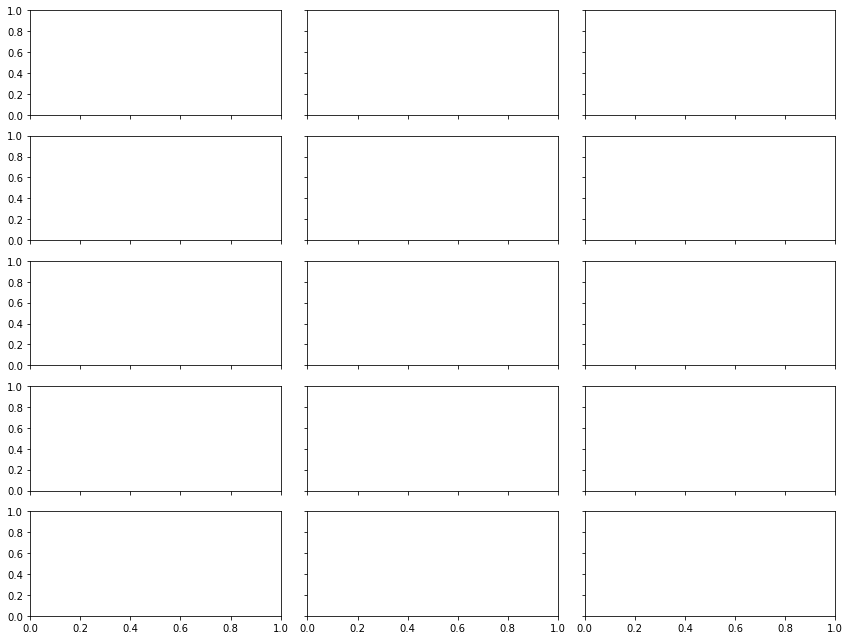

In [162]:
# Specify how many rows and columns you want to use in the following figure
# This will ofcourse depend an the number of variables you would like to plot
# You can also set the figure size
n_cols = 3
n_rows = 5

# Figure with single mineral maps as subplots
plots.plot_contour_map_all(interpolated_modal,
                           grid,
                           coordinates_utm,
                           group_name,
                           title=f"radius={range_[0]}m masked {critical_distance}m",
                           show_plot=True,
                           label_pos = (0.03, 0.94),
                           skip_xaxis_label=2,
                           skip_yaxis_label=2,
                           skip_xaxis_start=1,
                           skip_yaxis_start=1,
                           figsize=(12, 9),
                           ncols=n_cols,
                           nrows=n_rows,
                           sharex=True,
                           sharey=True)

## Biplots
____

Not relevant for now

## Simulations
____

Not relevant for now